# Padding with fitted background

 Chia-Hao Lee

cl2696@cornell.edu

Created 2025.02.24

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
work_dir = "H:\workspace\ptyrad"
os.chdir(work_dir)
print("Current working dir: ", os.getcwd())

Current working dir:  H:\workspace\ptyrad


In [3]:
from ptyrad.data_io import load_raw
from ptyrad.utils import create_one_hot_mask, fit_background, exponential_decay, power_law, vprint

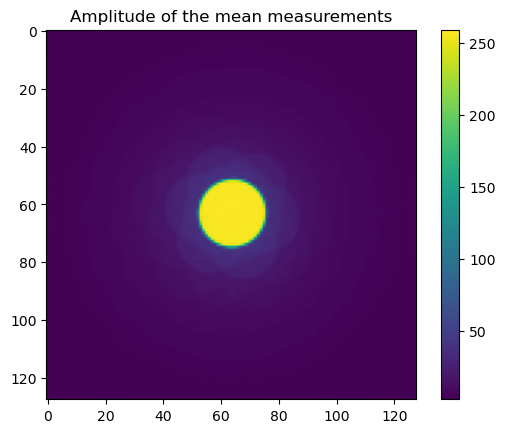

In [4]:
data_path = 'data/paper/tBL_WSe2/Panel_g-h_Themis/scan_x128_y128.raw'
cbed = load_raw(data_path, (16384,128,128))

plt.figure()
plt.title("Amplitude of the mean measurements")
plt.imshow(cbed.mean(0)**0.5)
plt.colorbar()
plt.show()

In [5]:
# Correct negative values
cbed[cbed<0] = 0

# Normalize so that the mean pattern has max at 1.
cbed = cbed / (np.mean(cbed, 0).max()) 
cbed = cbed.astype('float32')

print(f"cbed.min, mean, max = {(cbed.min(), cbed.mean(), cbed.max())}")
print(f"cbed_mean.min, mean, max = {(cbed.mean(0).min(), cbed.mean(0).mean(), cbed.mean(0).max())}")

meas = cbed

cbed.min, mean, max = (0.0, 0.027057525, 1.4820517)
cbed_mean.min, mean, max = (8.231122e-05, 0.027057568, 0.9999964)


In [6]:
mode         = 'precompute' # 'on_the_fly' or 'precompute'
padding_type = 'power' # Currently power law background seems to give the most natural result
target_Npix  = 256
value        = 0
threshold    = 90 # Choose the threshold (percentile) properly so the fitting region doesn't contain too much intensity. Lower threshold will use region closer to the edge for the fitting.
meas_avg     = meas.mean(0)
meas_int_sum = meas_avg.sum()
amp_avg      = np.sqrt(meas_avg)
shape = meas.shape[-2:]  # Assuming last two dimensions are spatial

# Calculate padding for each dimension
pad_y = max(0, target_Npix - shape[0])
pad_x = max(0, target_Npix - shape[1])

# Split padding evenly, handling odd cases
pad_y1, pad_y2 = pad_y // 2, pad_y - pad_y // 2
pad_x1, pad_x2 = pad_x // 2, pad_x - pad_x // 2

# Parse pad_h1, pad_h2, pad_w1, pad_w2
pad_h1 = pad_y1
pad_h2 = pad_y1+shape[0]
pad_w1 = pad_x1
pad_w2 = pad_x1+shape[1]

# Create coordinate grid for padding region
y, x = np.ogrid[:target_Npix, :target_Npix]
center = (shape[0] // 2 + pad_y1, shape[1] // 2 + pad_x1)
r = np.sqrt((y - center[0])**2 + (x - center[1])**2) + 1e-10 # so r is never 0

# Calculate the meas_padded
if padding_type == 'constant':
    amp_padded = np.pad(amp_avg, ((pad_y1, pad_y2), (pad_x1, pad_x2)), mode='constant', constant_values=value)
elif padding_type == 'edge':
    amp_padded = np.pad(amp_avg, ((pad_y1, pad_y2), (pad_x1, pad_x2)), mode='edge')
elif padding_type == 'linear_ramp':
    amp_padded = np.pad(amp_avg, ((pad_y1, pad_y2), (pad_x1, pad_x2)), mode='linear_ramp', end_values=value)
elif padding_type == 'exp':
    mask = create_one_hot_mask(amp_avg, percentile=threshold)
    popt = fit_background(amp_avg, mask, fit_type='exp')
    background = exponential_decay(r, *popt)
    amp_padded = background
elif padding_type == 'power':
    mask = create_one_hot_mask(amp_avg, percentile=threshold)
    popt = fit_background(amp_avg, mask, fit_type='power')
    background = power_law(r, *popt)
    amp_padded = background
else:
    raise KeyError(f"meas_pad does not support padding_type = '{padding_type}', please choose from 'constant', 'edge', 'linear_ramp', 'exp', or 'power'")

# Square the padded amplitude back to intensity
meas_padded = np.square(amp_padded)[None,] # (1, ky, kx)

# Parse intensity information
meas_padded[..., pad_h1:pad_h2, pad_w1:pad_w2] = 0
padded_int_sum = meas_padded.sum()
vprint(f"Original meas int sum = {meas_int_sum:.4f}, padded region int sum = {padded_int_sum:.4f}, or {padded_int_sum/meas_int_sum:.2%} more intensity after padding. This percentage should be ideally less than 5%, or you should set a lower threshold to exclude more central region.")

if mode == 'precompute':
    canvas = np.zeros((meas.shape[0], *meas_padded.shape[1:]))
    canvas += meas_padded
    canvas[..., pad_h1:pad_h2, pad_w1:pad_w2] = meas # Replace the center part with the original meas
    meas = canvas
elif mode == 'on_the_fly':
    pass
else:
    raise KeyError(f"meas_pad does not support mode = '{mode}', please choose from 'on_the_fly', 'precompute', or None")

Using percentile = 90.00% to create an one-hot mask for measurements amplitude background fitting
The mask has roughly 22.84 px in radius, or 0.36 of the distance from center to edge of the image
Fitted a = 8.6694, b = 1.5370 for power law decay: y = a*r^-b
Original meas int sum = 443.3112, padded region int sum = 2.3696, or 0.53% more intensity after padding. This percentage should be ideally less than 5%, or you should set a lower threshold to exclude more central region.


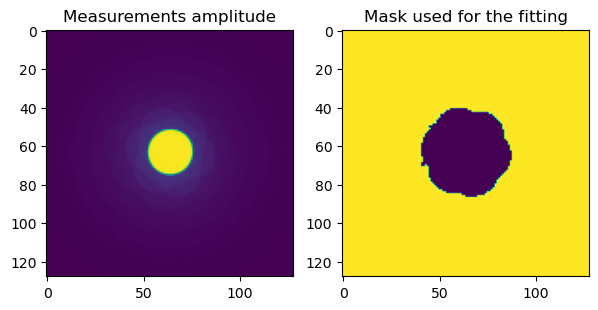

In [7]:
fig, axs = plt.subplots(1,2, figsize=(7,4))
axs[0].set_title("Measurements amplitude")
axs[1].set_title("Mask used for the fitting")
axs[0].imshow(cbed.mean(0)**0.5)
axs[1].imshow(mask)

plt.show()

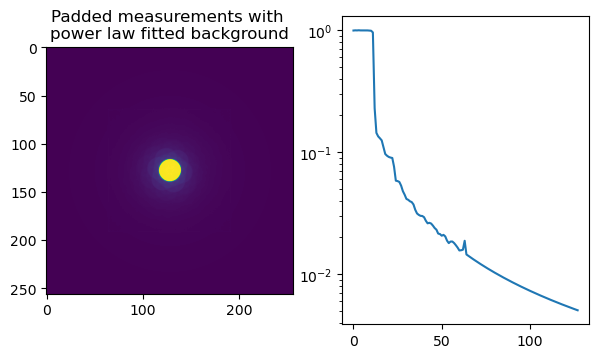

In [8]:
img = meas.mean(0)**0.5

fig, axs = plt.subplots(1,2, figsize=(7,4))
axs[0].set_title("Padded measurements with \npower law fitted background")
axs[0].imshow(img)
axs[1].plot(img[128,128:])
plt.yscale('log')
plt.show()

## Note
# If you see a small peak at the edge of the original data, you can consider cropping the data first before padding.
# This can be easily done in PtyRAD by setting 'meas_crop' simultaneously with 'meas_pad'

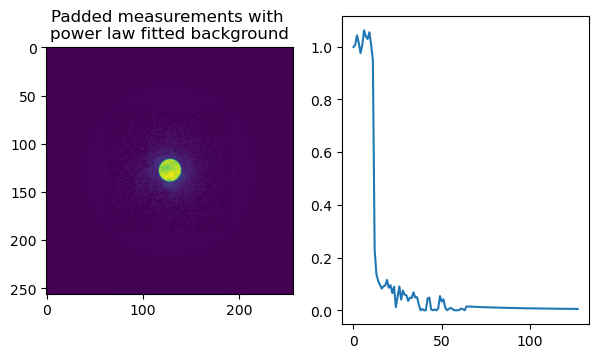

In [10]:
img = meas[1]**0.5

fig, axs = plt.subplots(1,2, figsize=(7,4))
axs[0].set_title("Padded measurements with \npower law fitted background")
axs[0].imshow(img)
axs[1].plot(img[128,128:])
plt.show()

## Note
# Single measurement is much more noisier so the log-y would show some very negative values
# However, for ptycho optimization purposes, the padded measurement is pretty smooth, at least visually